## Описание проекта

Сеть фитнес-центров «Культурист-датасаентист» разрабатывает стратегию взаимодействия с клиентами на основе аналитических данных. Цель проекта - провести анализ и подготовить план действий по удержанию клиентов.

Задачи проекта:

- спрогнозировать вероятность оттока (на уровне следующего месяца) для каждого клиента;
- сформировать типичные портреты клиентов: выделить несколько наиболее ярких групп и охарактеризовать их основные свойства;
- проанализировать основные признаки, наиболее сильно влияющие на отток;
- сформулировать основные выводы и разработать рекомендации по повышению качества работы с клиентами:

1) выделить целевые группы клиентов;

2) предложить меры по снижению оттока;

3) определить другие особенности взаимодействия с клиентами.

## Загрузка данных

In [60]:
import pandas as pd
import itertools
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from sklearn.cluster import KMeans
from scipy.cluster.hierarchy import dendrogram, linkage 

In [61]:
try:
    df = pd.read_csv('/datasets/gym_churn.csv', sep=',')

except:
    df = pd.read_csv('/Users/damayboroda/study/data_for_projects/gym_churn.csv', sep=',')

df.head()

,gender,Near_Location,Partner,Promo_friends,Phone,Contract_period,Group_visits,Age,Avg_additional_charges_total,Month_to_end_contract,Lifetime,Avg_class_frequency_total,Avg_class_frequency_current_month,Churn
0,1,1,1,1,0,6,1,29,14.227470,5.0,3,0.020398,0.000000,0
1,0,1,0,0,1,12,1,31,113.202938,12.0,7,1.922936,1.910244,0
2,0,1,1,0,1,1,0,28,129.448479,1.0,2,1.859098,1.736502,0
3,0,1,1,1,1,12,1,33,62.669863,12.0,2,3.205633,3.357215,0
4,1,1,1,1,1,1,0,26,198.362265,1.0,3,1.113884,1.120078,0


In [62]:
def show_info(df):
    # Выводим информацию о наборе данных с помощью display()
    print("Информация о наборе данных:")
    print(df.info())
    print('---------')
    # Выводим первые 5 строк датафрейма с помощью display()
    print("Первые 5 строк:")
    display(df.head())

show_info(df)

Информация о наборе данных:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4000 entries, 0 to 3999
Data columns (total 14 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   gender                             4000 non-null   int64  
 1   Near_Location                      4000 non-null   int64  
 2   Partner                            4000 non-null   int64  
 3   Promo_friends                      4000 non-null   int64  
 4   Phone                              4000 non-null   int64  
 5   Contract_period                    4000 non-null   int64  
 6   Group_visits                       4000 non-null   int64  
 7   Age                                4000 non-null   int64  
 8   Avg_additional_charges_total       4000 non-null   float64
 9   Month_to_end_contract              4000 non-null   float64
 10  Lifetime                           4000 non-null   int64  
 11  Avg_class_frequency_total   

,gender,Near_Location,Partner,Promo_friends,Phone,Contract_period,Group_visits,Age,Avg_additional_charges_total,Month_to_end_contract,Lifetime,Avg_class_frequency_total,Avg_class_frequency_current_month,Churn
0,1,1,1,1,0,6,1,29,14.227470,5.0,3,0.020398,0.000000,0
1,0,1,0,0,1,12,1,31,113.202938,12.0,7,1.922936,1.910244,0
2,0,1,1,0,1,1,0,28,129.448479,1.0,2,1.859098,1.736502,0
3,0,1,1,1,1,12,1,33,62.669863,12.0,2,3.205633,3.357215,0
4,1,1,1,1,1,1,0,26,198.362265,1.0,3,1.113884,1.120078,0


Датафрейм содержит 4000 наблюдений, 14 столбцов. Числовые данные представлены форматами int64 и float64. Категориальные переменные отсутствуют. Датафрейм не содержит пропусков.

## Описание данных

Набор данных включает следующие поля:

1. Данные клиента за предыдущий до проверки факта оттока месяц:
- 'Gender' — пол;
- 'Near_Location' — проживание или работа в районе, где находится фитнес-центр;
- 'Partner' — сотрудник компании-партнёра клуба (сотрудничество с компаниями, чьи сотрудники могут получать скидки на абонемент— в таком случае фитнес-центр хранит информацию о работодателе клиента);
- Promo_friends — факт первоначальной записи в рамках акции «приведи друга» (использовал промо-код от знакомого при оплате первого абонемента);
- 'Phone' — наличие контактного телефона;
- 'Age' — возраст;
- 'Lifetime' — время с момента первого обращения в фитнес-центр (в месяцах).

2. Информация на основе журнала посещений, покупок и информация о текущем статусе абонемента клиента:
- 'Contract_period' — длительность текущего действующего абонемента (месяц, 6 месяцев, год);
- 'Month_to_end_contract' — срок до окончания текущего действующего абонемента (в месяцах);
- 'Group_visits' — факт посещения групповых занятий;
- 'Avg_class_frequency_total' — средняя частота посещений в неделю за все время с начала действия абонемента;
- 'Avg_class_frequency_current_month' — средняя частота посещений в неделю за предыдущий месяц;
- 'Avg_additional_charges_total' — суммарная выручка от других услуг фитнес-центра: кафе, спорттовары, косметический и массажный салон.
- 'Churn' — факт оттока в текущем месяце.

## Исследовательский анализ данных (EDA)

Приведем названия столбцов к нижнему регистру для удобства.

In [63]:
df.columns = df.columns.str.lower()

Проверим датафрейм на полные дубликаты

In [64]:
df.duplicated().sum()

0

Полные дубликаты в df отсутствуют

Заменим для некоторых столбцов тип данных

In [65]:
df['month_to_end_contract'] = df['month_to_end_contract'].astype(int)

Выведем описательную статистику для датафрейма и посмотрим на std

In [66]:
df.describe()

,gender,near_location,partner,promo_friends,phone,contract_period,group_visits,age,avg_additional_charges_total,month_to_end_contract,lifetime,avg_class_frequency_total,avg_class_frequency_current_month,churn
count,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000
mean,0.510250,0.845250,0.486750,0.308500,0.903500,4.681250,0.412250,29.184250,146.943728,4.322750,3.724750,1.879020,1.767052,0.265250
std,0.499957,0.361711,0.499887,0.461932,0.295313,4.549706,0.492301,3.258367,96.355602,4.191297,3.749267,0.972245,1.052906,0.441521
min,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,18.000000,0.148205,1.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,1.000000,0.000000,0.000000,1.000000,1.000000,0.000000,27.000000,68.868830,1.000000,1.000000,1.180875,0.963003,0.000000
50%,1.000000,1.000000,0.000000,0.000000,1.000000,1.000000,0.000000,29.000000,136.220159,1.000000,3.000000,1.832768,1.719574,0.000000
75%,1.000000,1.000000,1.000000,1.000000,1.000000,6.000000,1.000000,31.000000,210.949625,6.000000,5.000000,2.536078,2.510336,1.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,12.000000,1.000000,41.000000,552.590740,12.000000,31.000000,6.023668,6.146783,1.000000


Чем ближе стандартное отклонение к 0, тем надежнее среднее. Более того, стандартное отклонение близкое к 0, говорит о маленькой вариабельности данных. В нашем случае std небольшие для всех переменных, кроме avg_additional_charges_total (суммарная выручка от других услуг фитнес-центра: кафе, спорттовары, косметический и массажный салон). Это может значить, что переменная может содержать выбросы - кто-то много тратит, а кто-то вообще не пользуется доп. услугами.

Переменная "churn" имеет 2 значения - 1 (клиент ушел) и 0 (клиент остался). Посмотрим, как отличаются средние признаков для каждого из значений этой переменной.

In [67]:
grouped_data = df.groupby('churn').mean()

# Установка опции отображения для максимальной ширины столбцов
pd.set_option('display.max_colwidth', None)

# Вывод результатов
display(grouped_data)

,gender,near_location,partner,promo_friends,phone,contract_period,group_visits,age,avg_additional_charges_total,month_to_end_contract,lifetime,avg_class_frequency_total,avg_class_frequency_current_month
churn,,,,,,,,,,,,,
0,0.510037,0.873086,0.534195,0.353522,0.903709,5.747193,0.464103,29.976523,158.445715,5.283089,4.711807,2.024876,2.027882
1,0.510839,0.768143,0.355325,0.183789,0.902922,1.728558,0.268615,26.989632,115.082899,1.662582,0.990575,1.474995,1.044546


- gender - булевая переменная (чем больше среднее, тем больше клиентов со значением 1). Примерно одинаковое количество мужчин и женщин посещает или посещало фитнес клубы
- near_location - большинство клиентов живут или работают рядом с фитнес клубами, у клиентов, которые ушли среднее значение меньше - это значит, что среди них меньшее количество живет или работает рядом с фитнес клубами
- partner - отток выше у тех, кто не работает в компании партнера сети фк. Можно предположить, что те, кто работают имеют большую лояльности к сети фк
- promo_friends - факт использования промо кода от друга при покупке первого абонемента - нечастное явление. Однако у среднее ближе к 1 у тех, кто не ушел из фк
- phone - 90% клиентов оставили контактный номер телефона, нет разницы ушли они или нет
- contract_period - у тех, кто ушел абонемент был оформлен на небольшой срок (почти 2 месяца среднее), а у тех, кто остался среднее - почти 6 месяцев. Возможно, что чем больше срок абонемента, тем меньше вероятность ухода, но это мы проверим далее
- group_visits - Меньше половины клиентов ходят на групповые занятия, однако среди тех, кто остался таких клиентов больше.
- age - средний возраст тех, кто остался и ушел примерно одинаковый - 30 и 27 лет.
- avg_additional_charges_total - средняя суммарная выручка от других услуг у тех, кто остался выше, может это связано с тем, что и ходят эти клиенты в среднем больше по времени в фк
- month_to_end_contract - оставшиеся клиенты -  у них среднее время до конца абонемента больше, а у ушедших среднее время до конца абонемента меньше.
- lifetime - те, кто дольше ходят, продолжают посещать фк, а вот ушли те, кто совсем недавно (в среднем месяц) пользуется услугами фк. Это могут быть клиенты, (1) которые купили абонемент, но так и не начали ходить или (2) те, кто быстро поняли, что либо им не нравится фк или вообще занятия фитнесом.
- avg_class_frequency_total - у тех, кто остался среднее количество занятий в неделю выше (2), чем среди тех, кто ушел (1)
- avg_class_frequency_current_month - стабильно продолжают заниматься 2 раза те, кто остался, а вот те, кто ушел занимались в предыдущий месяц до факта оттока только 1, в среднем, раз в неделю

Таким образом,
    
- partner признак влияет на отток
    
- contract_period, чем выше значение данного признака, тем чаще клиент остается, соответственно он крайне сильно влияет на отток
    
- group_visits, клиенты могут пользоваться групповыми занятиями, а это значит что если тут 1, то скорее всего клиент остается


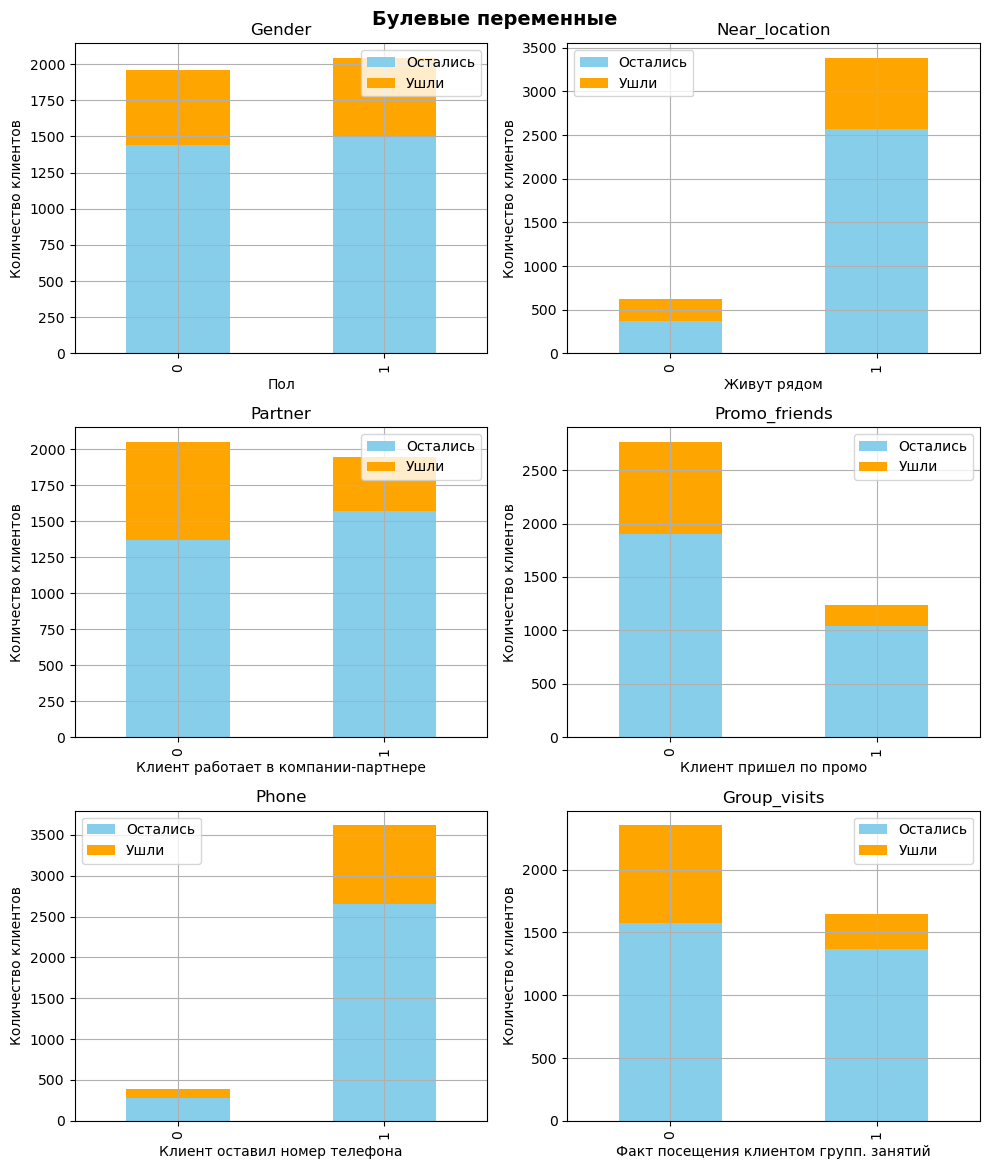

In [68]:
# Получаем фигуру и оси

import matplotlib.pyplot as plt

# Создаем фигуру и оси
fig, ((ax0, ax1), (ax2, ax3), (ax4, ax5)) = plt.subplots(nrows=3, ncols=2, figsize=(10, 12))

# Список для группировок и соответствующих названий
group_columns = [
    ('gender', 'Gender', 'Пол'),
    ('near_location', 'Near_location', 'Живут рядом'),
    ('partner', 'Partner', 'Клиент работает в компании-партнере'),
    ('promo_friends', 'Promo_friends', 'Клиент пришел по промо'),
    ('phone', 'Phone', 'Клиент оставил номер телефона'),
    ('group_visits', 'Group_visits', 'Факт посещения клиентом групп. занятий')
]

# Цикл для группировки и построения графиков
for i, (group_col, title, xlabel) in enumerate(group_columns):
    ax = locals()[f'ax{i}']
    df.groupby([group_col, 'churn']).size().unstack().plot(kind='bar', stacked=True, ax=ax, color=['skyblue', 'orange'])
    ax.legend(["Остались", "Ушли"])
    ax.set(title=title, xlabel=xlabel, ylabel='Количество клиентов')
    ax.grid(True)

# Подзаголовок фигуры
fig.suptitle('Булевые переменные', fontsize=14, fontweight='bold', y=0.97)


# Используем `plt.tight_layout()` для оптимизации расположения графиков на фигуре
plt.tight_layout()

# Показываем графики
plt.show()


В датафрейме:
- примерно одинаковое количество ж и м, как в группе оставшихся и ушедших
- большинство среди оставшихся и ушедших клиентов живут или работают рядом с фк
- доля ушедших клиентов выше среди тех, кто не работает в компании-партнере фк. Возможно, что работающие клиенты имеют большую лояльность поэтому и не уходят.
- среди клиентов, которые пришли по промо, доля ушедших меньше. Возможно, что у них был изначально интерес выше, чем у тех, которые пришли не по промо.
- практически все клиенты оставляли контактные данные (телефон)
- Среди клиентов, которые посещали групповые занятия, доля ушедших меньше - возможно, что их посещаемость дисциплинирует расписание или установление социальных контактов, возможно также тренера групповых занятий.


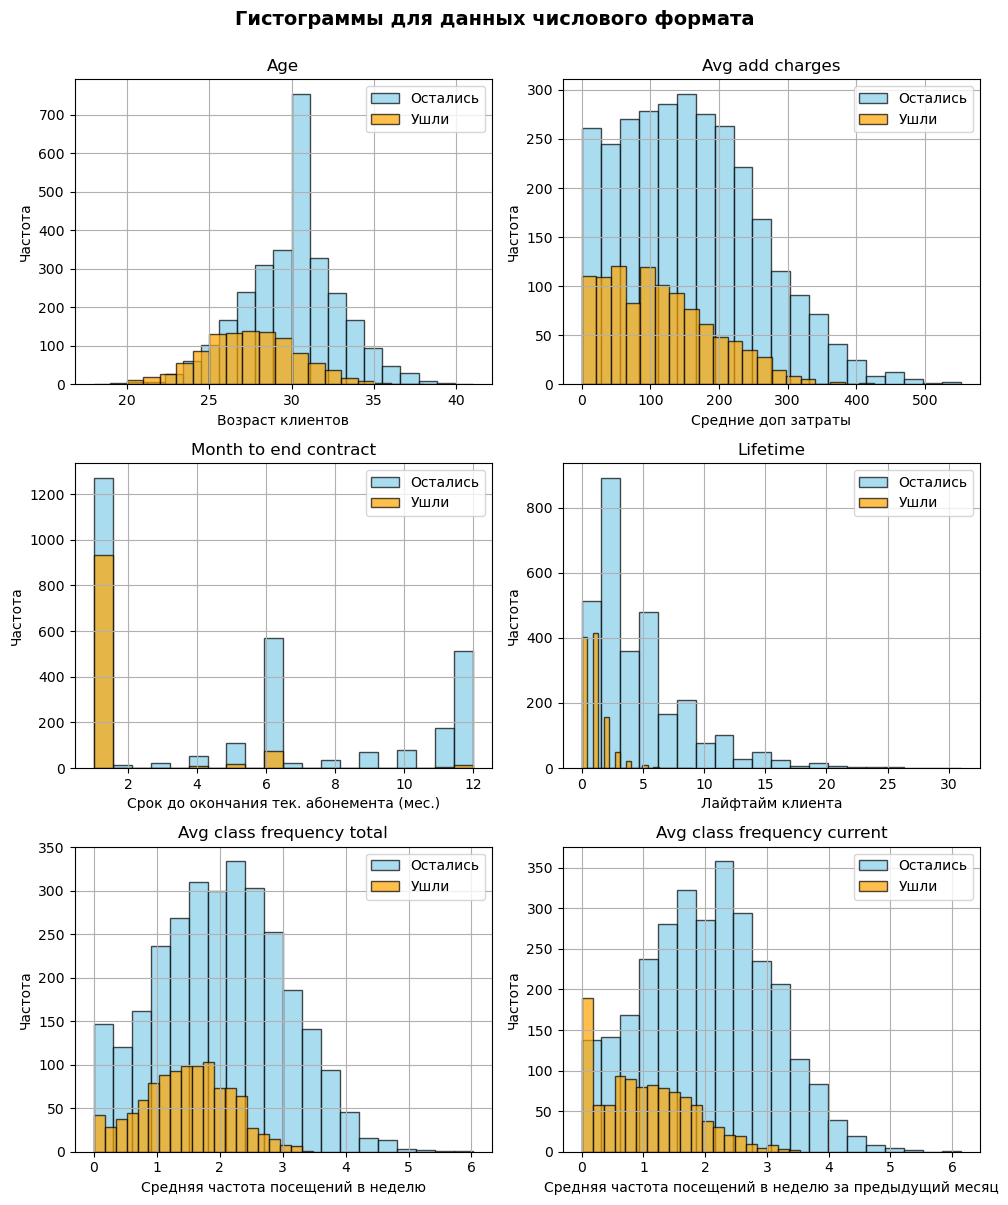

In [69]:

# Создаем фигуру и оси
fig, ((ax0, ax1), (ax2, ax3), (ax4, ax5)) = plt.subplots(nrows=3, ncols=2, figsize=(10, 12))

# Список для группировок и соответствующих названий
float_columns = [
    ('age', 'Age', 'Возраст клиентов'),
    ('avg_additional_charges_total', 'Avg add charges', 'Средние доп затраты'),
    ('month_to_end_contract', 'Month to end contract', 'Cрок до окончания тек. абонемента (мес.)'),
    ('lifetime', 'Lifetime', 'Лайфтайм клиента'),
    ('avg_class_frequency_total', 'Avg class frequency total', 'Средняя частота посещений в неделю'),
    ('avg_class_frequency_current_month', 'Avg class frequency current', 'Средняя частота посещений в неделю за предыдущий месяц')]

# Цикл для построения гистограмм
for i, (column, title, description) in enumerate(float_columns):
    ax = locals()[f'ax{i}']
    ax.hist(df[df['churn'] == 0][column], bins=20, color='skyblue', edgecolor='black', alpha=0.7, label='Остались')
    ax.hist(df[df['churn'] == 1][column], bins=20, color='orange', edgecolor='black', alpha=0.7, label='Ушли')
    ax.set(title=title, xlabel=description, ylabel='Частота')
    ax.legend()
    ax.grid(True)

# Подзаголовок фигуры
fig.suptitle('Гистограммы для данных числового формата', fontsize=14, fontweight='bold', y=1)

# Используем `plt.tight_layout()` для оптимизации расположения графиков на фигуре
plt.tight_layout()

# Показываем графики
plt.show()


- Более молодые клиенты уходят
- Уходят клиенты, которые тратят меньше на дополнительные услуги
- У большинства ушедших клиентов абонемент был оформлен на месяц, у многих и оставшихся аналогично, но зато только у них от 7 мес и более
- Уходят клиенты с лайфтаймом менее 5 месяцев, а самый частый лайфтайм ушедших - 1-2 мес
- Ушедшие клиенты посещают занятия примерно как и оставшиеся - наиболее часто около 2 рах в неделю, но зато среди оставшихся есть те, кто занимаются 3-4 раза
- Точно, что у если клиент решил уйти, то он в последний месяц перестает ходить на занятия в большинстве случаев

<div class="alert alert-block alert-success">
<b>Успех👍:</b> 
    
Прекрасные графики вышли, ты прекрасно расписала два типа данных: категориальные и количественные, для каждой группы выбрала разные типы графиков - умница, ведь так ты смогла грамотно показать распределение данных
</div>

Посмотрим матрицу корреляции и отобразим ее

<AxesSubplot:>

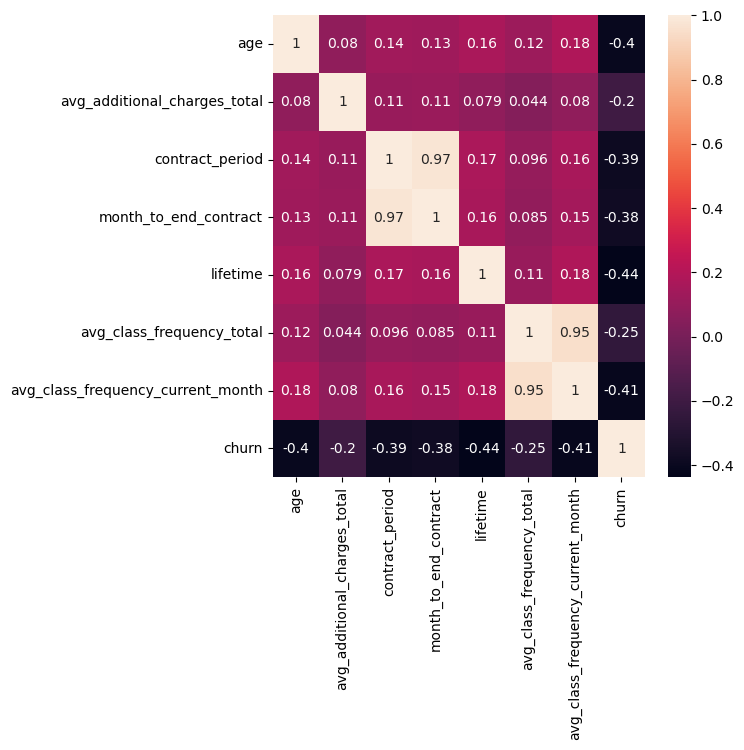

In [70]:
fig, ax = plt.subplots(figsize=(6, 6))
corr_matrix = df[['age', 'avg_additional_charges_total', 'contract_period', 'month_to_end_contract', 'lifetime',\
                    'avg_class_frequency_total', 'avg_class_frequency_current_month', 'churn']].corr()
sns.heatmap(corr_matrix, annot=True)

Матрица корреляции показывает, что признаки не сильно коррелируют между собой, исключение, где коэффициент > по модулю 0,8 - month_to_end_contract и contract_period + avg_class_frequency_total и avg_class_frequency_current_month , что и логично. Можно удалить из датафрейма одну для каждой пары коррелирующих, чтобы избежать мультиколлинеарности.

На факт оттока клиентов больше всего влияют:
- lifetime клиента влияет отрицательно (коэффициент -0,44), то есть чем меньше лайфтайм, тем больше вероятность оттока
- avg_class_frequency_current_month (среднее количество посещений в неделю за последний месяц) (коэффициент -0,41) влияет отрицательно, то есть чем меньше количество посещений в неделю за последний месяц, тем больше вероятность оттока
- age (коэффициент -0,4) - чем меньше возраст, тем больше ворятность оттока? Возраст как признак не всегда корректно рассматривать...?
- contract_period (коэффициент -0,39) также отрицательно влияет на факт оттока - чем меньше срок абонемента, тем больше вероятность ухода клиента.

Практически никак не влияют (коэффициент около нуля) на целевую перменную (факт оттока):
- признаки gender и phone (наличие контактного номера)

### Выводы

- Данные не содержат пропусков
- У двух признаков выявлена сильная корреляция - month_to_end_contract и contract_period, что логично
- Призники имеют отрицательную взаимосвязь с целевой переменной - чем меньше их значение, тем больше вероятность факта оттока
- Наиболее ценными для модели исходя из анализа корреляций могут быть числовые признаки, в частности - lifetime, avg_class_frequency_current_month, contract_period 
- Выбросы в данных есть, но некритичные. Кроме того, наша модель нелинейная, она устройчива к выбросам + данных не так много (4000 наблюдений), поэтому не будем их удалять

## Модель прогнозирования оттока клиентов

Разделим наши данные на признаки (матрица X) и целевую переменную (y)

In [71]:
X = df.drop('churn', axis=1)
y = df['churn']

In [72]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

Стандартизируем данные

In [73]:
#создадим объект класса StandardScaler и применим его к обучающей выборке
scaler = StandardScaler()
X_train_st = scaler.fit_transform(X_train) 
display(X_train_st[:5])

#применяем стандартизацию к матрице признаков для тестовой выборки
X_test_st = scaler.transform(X_test) 

array([[-1.01511421,  0.4175068 ,  1.03175391,  1.4800097 ,  0.31628211,
         1.60502986, -0.84769226,  0.57944798,  0.37161711,  1.59173796,
         1.12734972,  1.75580418,  1.61822807],
       [-1.01511421,  0.4175068 , -0.96922337, -0.67567125,  0.31628211,
        -0.81299073, -0.84769226,  0.27046055, -1.09697378, -0.79568246,
         5.88138322, -0.2239674 , -0.01340886],
       [ 0.98511083,  0.4175068 ,  1.03175391, -0.67567125,  0.31628211,
         1.60502986, -0.84769226, -0.65650171, -1.18374157,  1.83048   ,
         0.3350108 , -0.84308456, -0.80541199],
       [-1.01511421,  0.4175068 ,  1.03175391,  1.4800097 ,  0.31628211,
         0.28610954, -0.84769226, -0.96548914, -0.95158829,  0.39802775,
         1.39146269,  0.66771379,  0.64605224],
       [-1.01511421,  0.4175068 , -0.96922337, -0.67567125, -3.16173427,
        -0.81299073, -0.84769226, -0.03852687,  0.97190435, -0.79568246,
         0.07089783, -0.19587934, -0.16038147]])

### Логистическая регрессия

In [74]:
lr_model = LogisticRegression(random_state=0)

# обучите модель
lr_model.fit(X_train_st, y_train)

# воспользуйтесь уже обученной моделью, чтобы сделать прогнозы
lr_predictions = lr_model.predict(X_test_st)
lr_probabilities = lr_model.predict_proba(X_test_st)[:,1]

In [75]:
def print_all_metrics(y_true, y_pred, y_proba, title = 'Метрики классификации'):
    print(title)
    print('\tAccuracy: {:.3f}'.format(accuracy_score(y_true, y_pred)))
    print('\tPrecision: {:.3f}'.format(precision_score(y_true, y_pred)))
    print('\tRecall: {:.3f}'.format(recall_score(y_true, y_pred)))
    print('\tF1: {:.3f}'.format(f1_score(y_true, y_pred)))
    print('\tROC_AUC: {:.3f}'.format(roc_auc_score(y_true, y_proba)))

In [76]:
print_all_metrics(y_test, lr_predictions, lr_probabilities , title='Метрики для модели логистической регрессии:')

Метрики для модели логистической регрессии:
	Accuracy: 0.922
	Precision: 0.854
	Recall: 0.828
	F1: 0.841
	ROC_AUC: 0.971


### Модель случайного леса

In [77]:
rf_model = RandomForestClassifier(n_estimators = 100, random_state=0)
# обучим модель случайного леса
rf_model.fit(X_train_st, y_train)
# воспользуемся уже обученной моделью, чтобы сделать прогнозы
rf_predictions = rf_model.predict(X_test_st)
rf_probabilities = rf_model.predict_proba(X_test_st)[:, 1]
print_all_metrics(y_test, rf_predictions, rf_probabilities , title='Метрики для модели случайного леса:')

Метрики для модели случайного леса:
	Accuracy: 0.915
	Precision: 0.839
	Recall: 0.813
	F1: 0.826
	ROC_AUC: 0.968


### Выводы

- accuracy в данном случае не очень показательна, так как у нас объектов каждого класса не равное количество - больше тех, кто остался.
- recall (полнота) выше (ближе к 1) у модели логистической регрессии
- precision (точно) выше у модели логистической регрессии
- F1 (баланс recall и precision) лучше у модели случайного леса
- Поэтому посмотрим еще и на ROC_AUC - эта метрика лучше у логистической регрессии

Таким образом, логистическая модель показала себя лучше.

## Кластеризация клиентов

Стандартизуем данные 

In [78]:
sc = StandardScaler()
x_sc = sc.fit_transform(X)

Построим матрицу расстояний функцией linkage() на стандартизованной матрице признаков и нарисуем дендрограмму

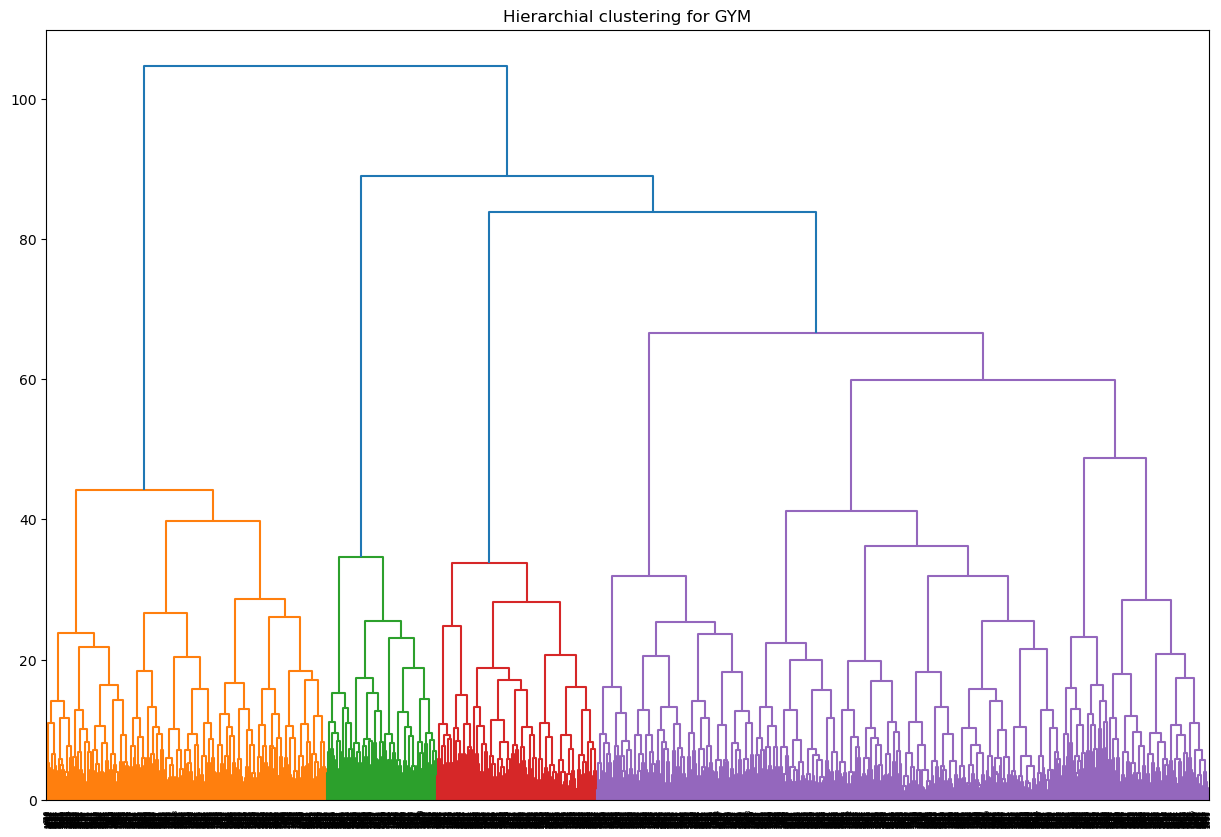

In [79]:
linked = linkage(x_sc, method = 'ward')
plt.figure(figsize=(15, 10))  
dendrogram(linked, orientation='top')
plt.title('Hierarchial clustering for GYM')
plt.show() 

Предложенное оптимальное число кластеров 4, однако возьмем 5 в соответствии с инструкцией к проекту.

Обучим модель кластеризации на основании алгоритма K-Means и спрогнозируем кластеры клиентов. Договоримся за число кластеров принять n=5.

In [80]:
# задаём модель k_means с числом кластеров 3 и фиксируем значение random_state
km = KMeans(n_clusters=5, random_state=0)
# прогнозируем кластеры для наблюдений (алгоритм присваивает им номера от 0 до 4)
labels = km.fit_predict(x_sc)

# сохраняем метки кластера в поле нашего датасета
df['cluster_km'] = labels

# выводим статистику по средним значениям наших признаков по кластеру
clusters = df.groupby('cluster_km').mean()
display(clusters)

,gender,near_location,partner,promo_friends,phone,contract_period,group_visits,age,avg_additional_charges_total,month_to_end_contract,lifetime,avg_class_frequency_total,avg_class_frequency_current_month,churn
cluster_km,,,,,,,,,,,,,,
0,0.502970,0.959406,0.783168,0.574257,1.000000,10.889109,0.542574,29.982178,160.761016,9.954455,4.736634,1.982055,1.974789,0.027723
1,0.522078,0.862338,0.470130,0.306494,0.000000,4.787013,0.425974,29.301299,143.957664,4.475325,3.924675,1.847220,1.716369,0.267532
2,0.495050,0.000000,0.463366,0.079208,1.000000,2.352475,0.215842,28.477228,135.457501,2.198020,2.809901,1.660461,1.477324,0.443564
3,0.485737,1.000000,0.350238,0.240095,1.000000,1.948494,0.341521,28.167987,131.622204,1.856577,2.440571,1.247634,1.012983,0.514263
4,0.559666,0.976134,0.356802,0.230310,0.998807,2.669451,0.473747,30.125298,161.657905,2.459427,4.898568,2.852002,2.850161,0.068019


Посмотим также, какое количество клиентов в каждом из кластеров

In [81]:
df['cluster_km'].value_counts()

3    1262
0    1010
4     838
2     505
1     385
Name: cluster_km, dtype: int64

По средним значениям признаков можно описать кластеры следующим образом:
- 0 кластер - клиенты, которые живут/ работают рядом с фк, работают в компаниях партнерах, пришли по промо, абонемент был заключен долгорочно, посещают групповые занятия (50 на 50), 30 лет, высокие затраты на доп услуги, осталось 10 месяцев до окончания абонемента, 5 месяцев лайфтайм, ходят 2 раза в неделю, количество посещений не снижается, не в оттоке
- 1 кластер - клиенты, которые живут/работают рядом с фк, не работают в компаниях партнерах, пришли не по промо, среднесрочный абонемент, не посещают групповые занятия, 29 лет, средние траты на доп услуги, 5 мес до окончания абонемента, лайфтайм 4 мес., ходят 2 раза в неделю, посещаемость снизилась, есть отток 20%, единственный кластер, в котором клиенты не оставляют контактный телефон
- 2 кластер - клиенты, которые не живут/ не работают рядом с фк, не работают в компаниях партнерах, не пришли по промо, абонемент краткосрочный, не ходят на групповые занятия, 28 лет, низкие по сравнению с другими кластерами дополнительные затрыты, 2 мес. до окончания абонемента, лайфтайм 3 мес, 2 занятия в неделю, в последнем месяце посещаемость упала до 1 занятия в неделю, практически половина ушла в отток
- 3 кластер - клиенты, которые живут/работают рядом с фк, не работают в компаниях партнерах, не пришли по промо, абонемент на 2 мес, не ходят на групп занятия, 28 лет, самые низкие затраты на доп услуги, 2 месяца до окончания абонемента, 2 месяца лайфтайм, 1 раз в неделю посещают фк, посещаемость снизилась в последний месяц, более половины клиентов в отток
- 4 кластер - клиенты, которые живут/работают рядом с фк, не работают в компаниях партнерах, пришли не по промо, абонемент на 3 месяца, почти половина ходит на групповые занятия, 30 лет, высокие дополнительные затраты, 3 месяца до окончания абонемента, 5 месяцев лайфтайм, 3 раза в неделю ходят и продолжают ходить стабильно, нет оттока

На основе полученных кластеров можно предположить, что самые лояльные клиенты в 0 кластере
- самые замотивировованные в тренеровках в кластере 4
- самые незамотивированные в кластере 3

Какие кластеры склонны к оттоку?

- 2 (44%) и 3 (51%) кластер больше всего склонны к оттоку
- самые надежные - кластеры 0 (отток 3%) и 4 (отток 7%)
- 1 кластер - клиенты, которые потенциально имеют риск к оттоку (27%)

Так как самый многочисленный кластер 3 нужно обратить на него внимание в первую очередь:
- можно предложить абонемент на выгодных условиях, так как до окончания действующего осталось 2 месяца, желательно долгосрочный, так как клиенты, которые заключают такие абонементы меньше склонны к оттоку, также нужно простимулировать посещаемость

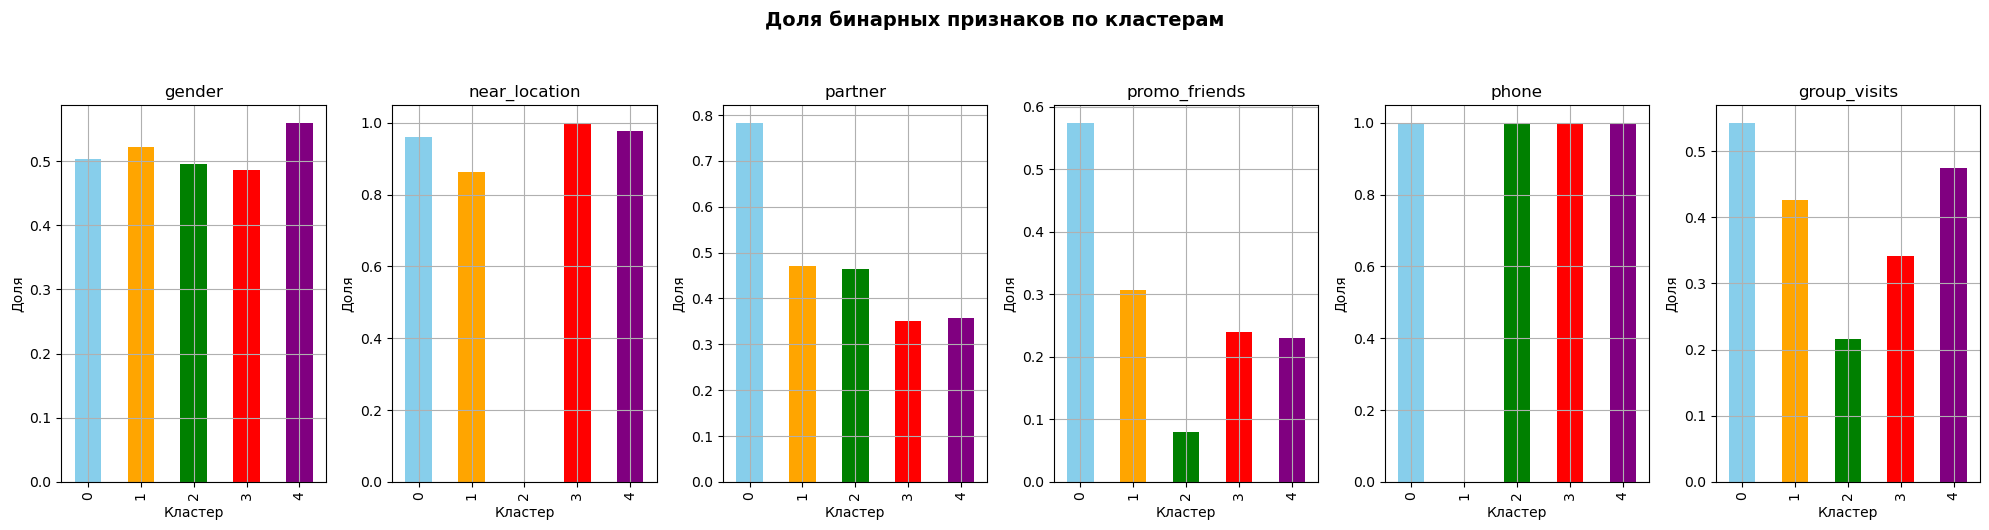

In [82]:
grouped_df = clusters.groupby('cluster_km')[['gender', 'near_location', 'partner', 'promo_friends', 'phone', 'group_visits']].mean()

# Столбчатая диаграмма для визуализации доли категорий признаков
fig, axes = plt.subplots(nrows=1, ncols=len(grouped_df.columns), figsize=(20, 5))

for i, column in enumerate(grouped_df.columns):
    ax = axes[i]
    grouped_df[column].plot(kind='bar', ax=ax, color=['skyblue', 'orange', 'green', 'red', 'purple'])
    ax.set_xlabel('Кластер')
    ax.set_ylabel('Доля')
    ax.set_title(f'{column}')
    ax.set_xticks(grouped_df.index)
    ax.set_xticklabels(grouped_df.index)
    ax.grid(True)

plt.suptitle('Доля бинарных признаков по кластерам', fontsize=14, fontweight='bold', y=1.05)
plt.tight_layout()
plt.show()


Из графика видно, что 
- пол 1 преобладает в 4 кластере,
- клиенты всех кластеров кроме 2 живут или работают рядом с фк,
- клиенты в 0 кластере работают на компании партнеров, также они пришли по промо, 
- клиенты только в 1 кластере не оставили контактный номер телефона,
- клиенты 2 кластера не посещают групповые занятия, а вот в 0 посещают

Определим функцию отрисовки графиков попарных числовых признаков для кластеров

In [83]:
def show_clusters_on_plot(df, x_name, y_name, cluster_name):
    plt.figure(figsize=(5, 5))
    sns.scatterplot(
        x=df[x_name], y=df[y_name], hue=df[cluster_name], palette='Paired'
    )
    plt.title('{} vs {}'.format(x_name, y_name))
    plt.show()

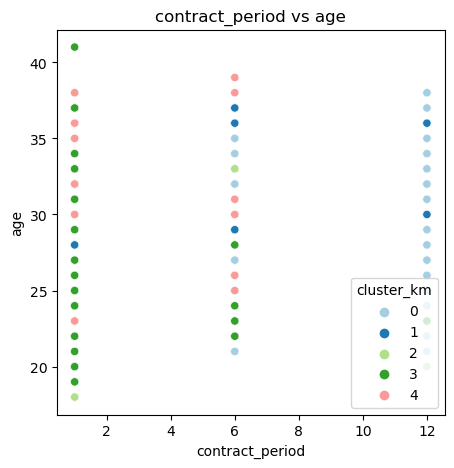

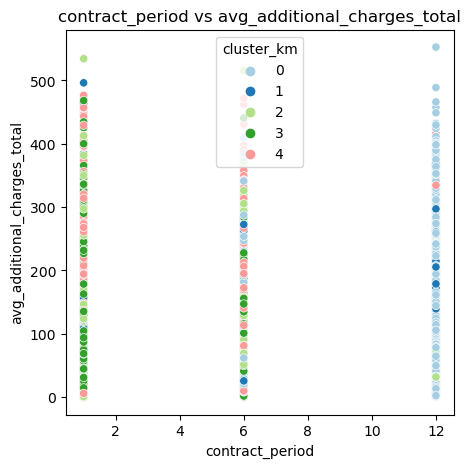

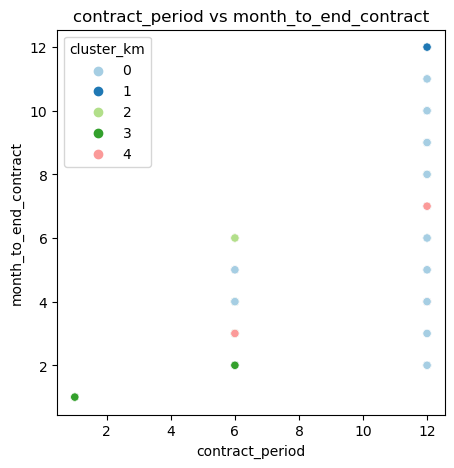

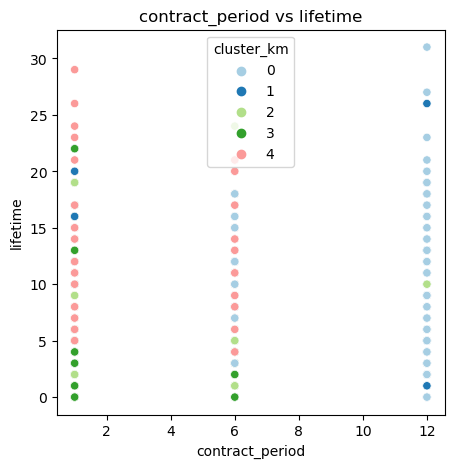

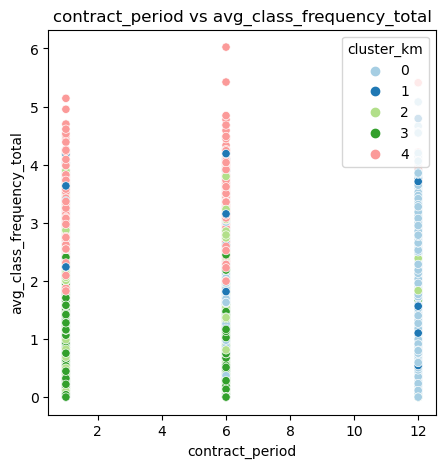

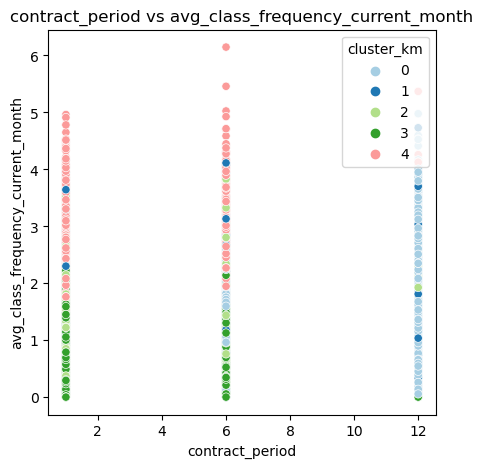

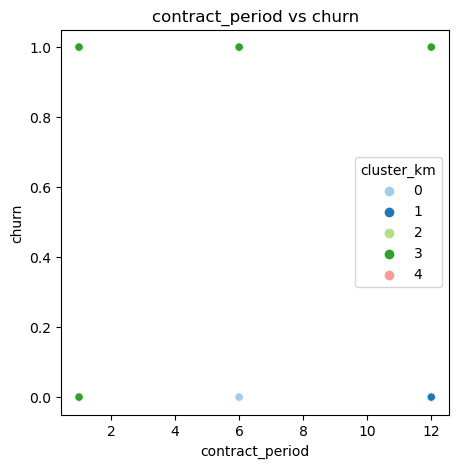

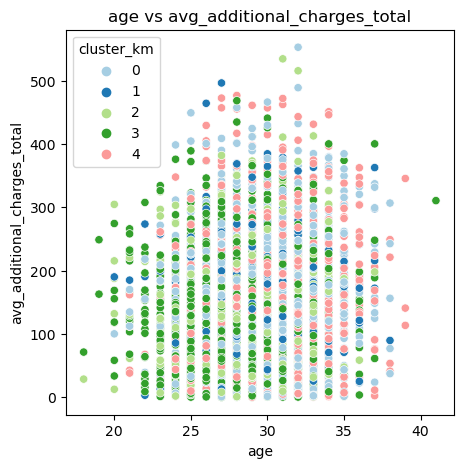

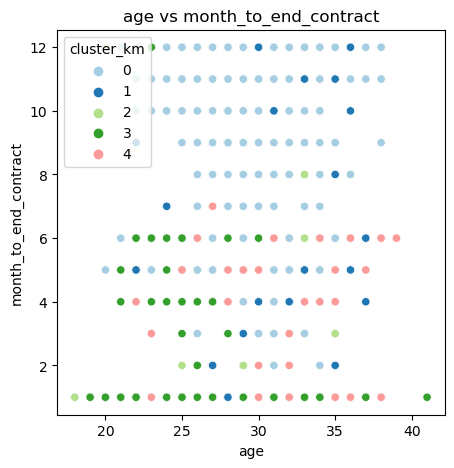

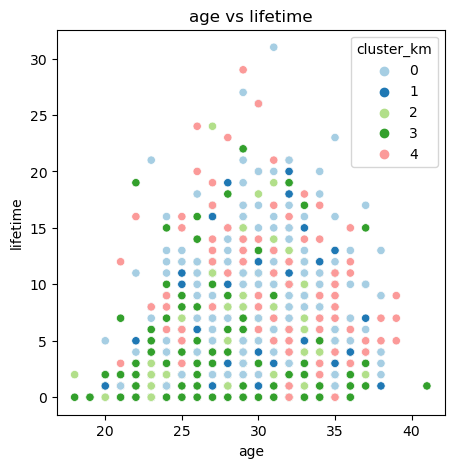

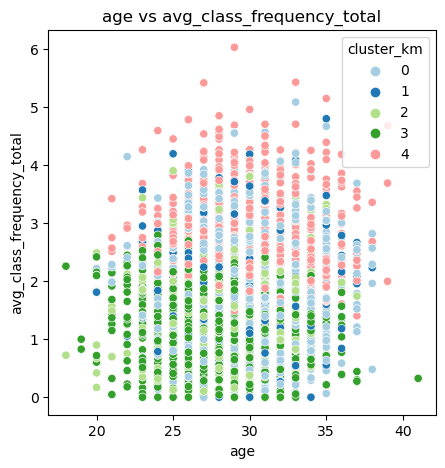

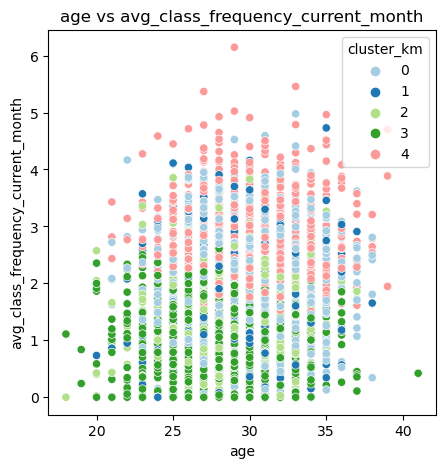

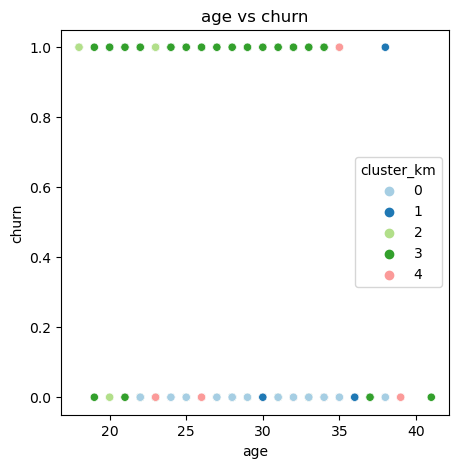

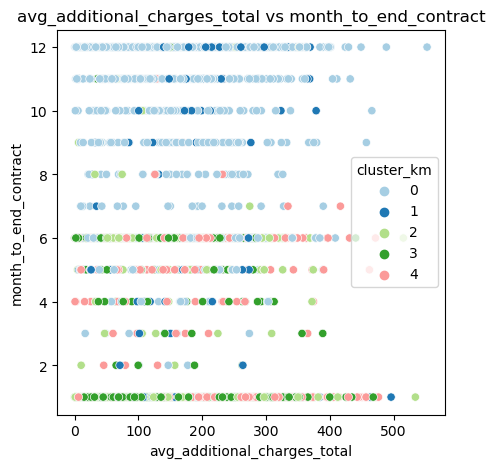

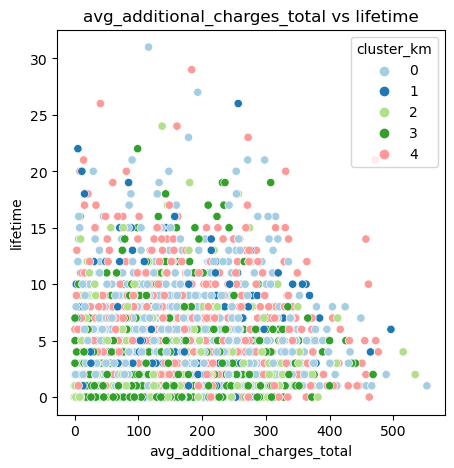

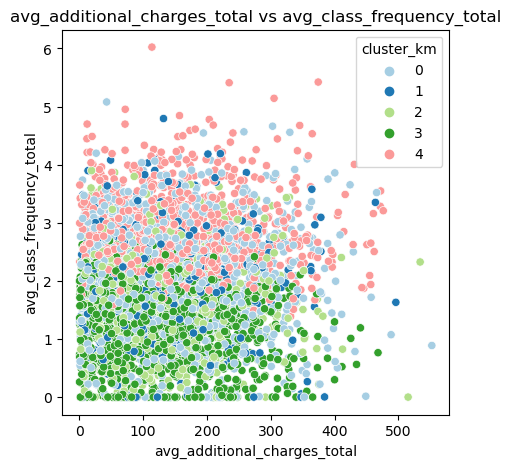

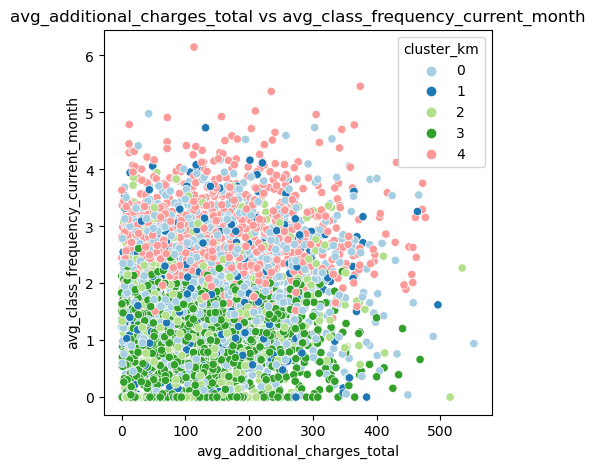

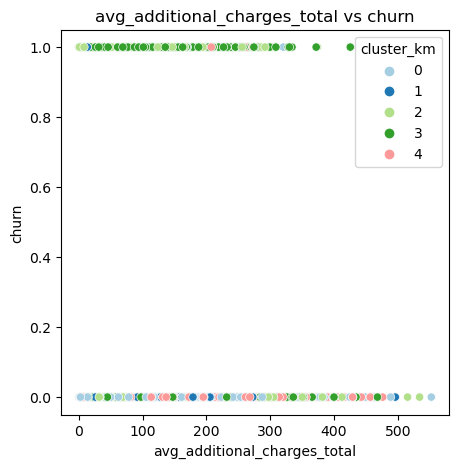

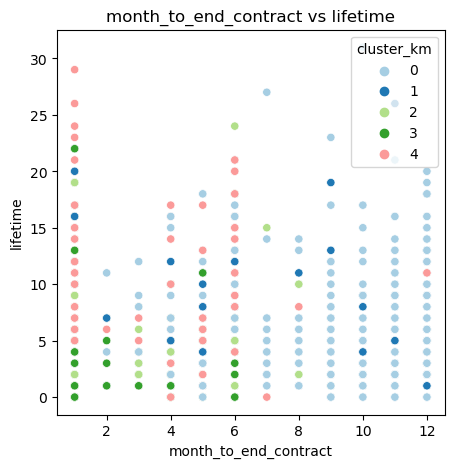

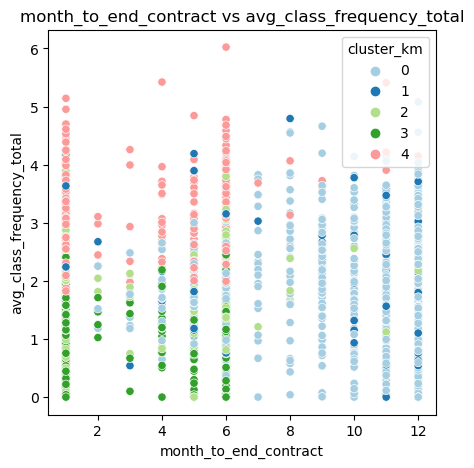

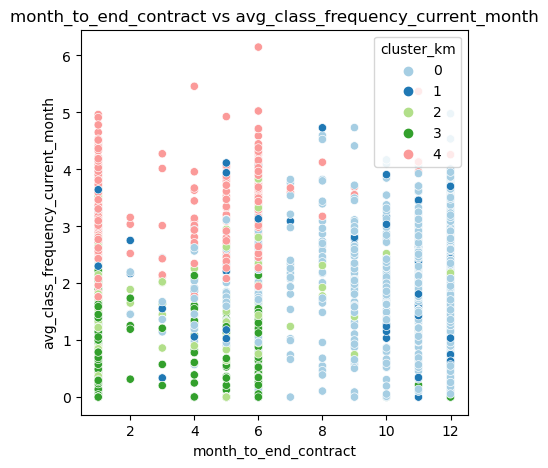

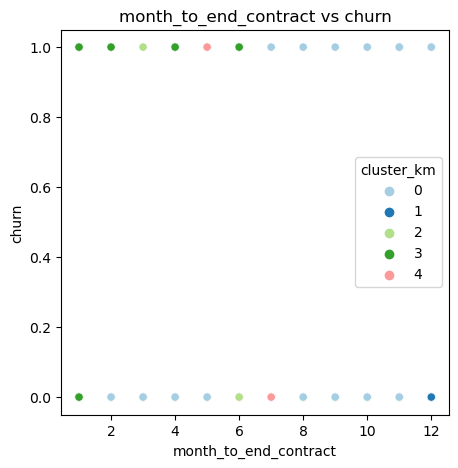

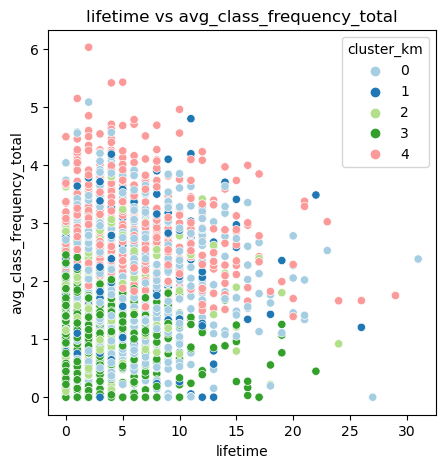

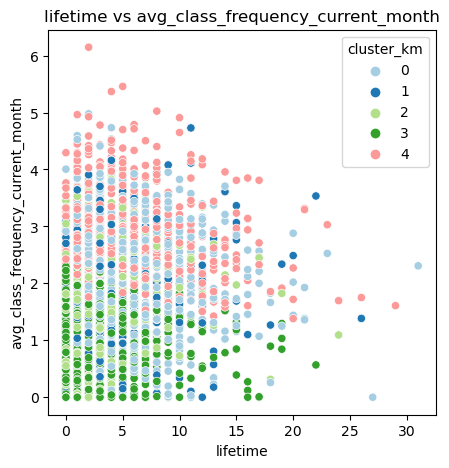

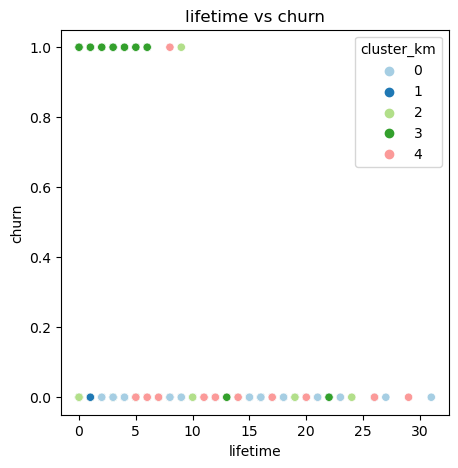

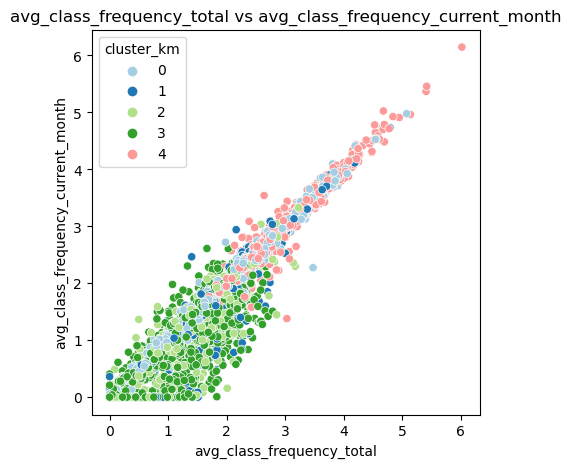

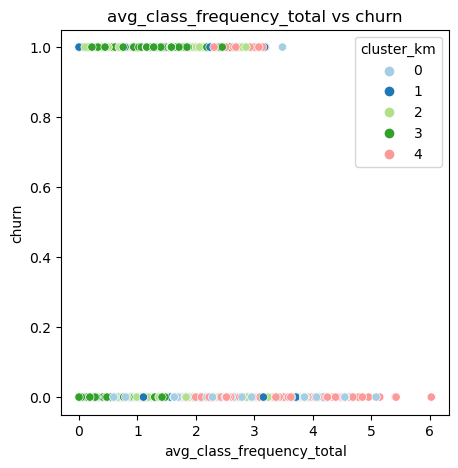

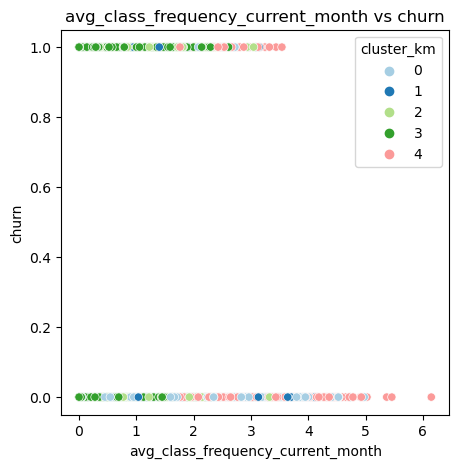

In [84]:
# отрисуем графики для попарных сочетаний признаков с разметкой по кластерам
col_pairs = list(itertools.combinations(df.drop(['gender', 'near_location', 'partner', 'promo_friends', 'phone', 'group_visits','cluster_km'], axis=1).columns, 2))
for pair in col_pairs:
    show_clusters_on_plot(df, pair[0], pair[1], 'cluster_km')

- Абонементы заключают на 1, 6 и 12 месяцев, причем в 0 кластере как правило на 12
- клиенты 4 кластера заключают абонементы на месяц и ходят часто (более 2 раз в неделю), также в 4 кластере есть те, кто ходит более 2 раз в неделю с абонементов на 6 месяцев, в 0 кластере ходят на занятия по-разному - кто один, а кто 3 и более раз в неделю, а кластеры с оттоком (2 и 3) как посещали редко фк, так и посещают
- у 3 кластера отток стабилен для всех сроков абонемента
- в 4 кластере самая активная посещаемость

## Выводы и рекомендации по работе с клиентами

- Построение моделей:

При построении моделей прогнозирования оттока клиентов были использованы модели "Логистическая регрессия" и "Случайный лес". Обе модели показали хорошие результаты. Модель логистической регрессии оказалась лучше по оценке ROC AUC.

- Кластеризация:

В результате анализа можно было разбить клиентов на 4 класса, но было принято решение разбить клиентов на 5 кластеров, кластеры можно описать следующим образом

**Кластер 0 (1010 человек) - самый низкий отток (3%):**

Клиенты, которые купили абонемент на 12 месяцев, живут/работают рядом, участиники промо и акция партнерства, лайфтайм 5 месяцев, ходят 2-3 раза в неделю стабильно, ходят на групповые занятия, абонемент заканчивается не скоро, тратят много на доп услуги

**Кластер 1 (385 человек - самый малочисленный) - отток 27%:**

Клиенты, которые купили среднесрочный абонемент, живут/работают рядом, пришли без акций, ходят 2 раза в неделю и посещаемость снижается, абонемент заканчивается не скоро, не ходят на групповые занятия, лайфтайм 4 месяца, не оставили контактные данные  

**Кластер 2 (505 человек) - отток 44%:**

Это те клиенты, кто живет или работет не рядом, пришли без промо-акции, сильно упала посещаемость в последний месяц, купили абонемент краткосрочный и он скоро закончится 

**Кластер 3 (1262 человек - самый многочисленный) - отток 51%:**

Клиенты, которые купили крактосрочный абонемент, живут или работают рядом, пришли не по акциям, тратят на доп услуги меньше всего, младше остальных клиентов по возрасту, небольшой лайфтайм и скоро абонемент закончится, ходят очень редко и посещаемость снизилась в последний месяц

**Кластер 4 (838 человек) - отток 7%:**

Клиенты, которые купили среднесрочный абонемент, живут или работают рядом, пришли не по акциям, ходят на групповые занятия, преобладает пол 1, абонемент скоро закончится, высокая посещаемость, ходят на групповые занятия


- Рекомендации:

1. Стимулировать программу лояльности (партнерские компании) и промоакции (это работает на примере 0 кластера)
2. Клиенты, которые заключают долгосрочный абонемент имеют меньше вероятность к оттоку - предлагать выгодные долгосрочные абонементы
3. Поддерживать коммуникацию с теми, у кого заканчивается абонемент, предлагая персонализированные предложения
4. Стимулировать посещаемость 

Так как самый многочисленный кластер 3 нужно обратить на него внимание в первую очередь:
- можно предложить абонемент на выгодных условиях, так как до окончания действующего осталось 2 месяца, желательно долгосрочный, так как клиенты, которые заключают такие абонементы меньше склонны к оттоку, также нужно простимулировать посещаемость